## 神经网络解决方案

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
train_set = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# Download and load the test data
test_set = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

import helper

In [3]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        super().__init__()
        
        # MouduleList
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])]) ## 第一层
        
        # 避免硬编码
        # hidden_layers[:-1]：1-倒数第二
        # hidden_layers[1:]：2-最后
        # zip后为前后两个元素组成的tuple
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        
        # 扩展隐藏层
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1,h2 in layer_sizes])
        
        # 输出层
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        # 按一定的概率关闭结点，防止过拟合
        self.dropout = nn.Dropout(p=drop_p)
    
    def forward(self, x):
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)  # 对数概率
        

In [7]:
model = Network(784, 10, [500], drop_p=0.5)
criterion = nn.NLLLoss()  # 负对数损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
## 训练网络
epochs = 2
steps = 0
running_loss = 0
print_every = 40

for e in range(epochs):
    ## 训练模式下，dropout开启
    model.train()
    for images, labels in iter(train_loader):
        steps += 1
        images.resize_(images.shape[0], 784)
        
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        
        output = model.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            ## 推断模式（预测）下，关闭dropout
            model.eval()
            
            accuracy = 0
            test_loss = 0
            
            for ii, (images, labels) in enumerate(test_loader):
                images = images.resize_(images.shape[0], 784)
                with torch.no_grad():  # 不计算梯度
                    inputs = Variable(images)
                    labels = Variable(labels)
                    
                    output = model.forward(inputs)
                    test_loss += criterion(output, labels).item()
                    
                    ## output为对数概率，要进行exp
                    ps = torch.exp(output).data
                    equality = (labels.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
                          "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
            running_loss = 0
                    
            # 开启dropout
            model.train()
                
                
                

Epoch: 1/2..  Training Loss: 1.062..  Test Loss: 0.707..  Test Accuracy: 0.742
Epoch: 1/2..  Training Loss: 0.677..  Test Loss: 0.639..  Test Accuracy: 0.769
Epoch: 1/2..  Training Loss: 0.631..  Test Loss: 0.588..  Test Accuracy: 0.779
Epoch: 1/2..  Training Loss: 0.595..  Test Loss: 0.579..  Test Accuracy: 0.776
Epoch: 1/2..  Training Loss: 0.581..  Test Loss: 0.542..  Test Accuracy: 0.800
Epoch: 1/2..  Training Loss: 0.601..  Test Loss: 0.521..  Test Accuracy: 0.808
Epoch: 1/2..  Training Loss: 0.583..  Test Loss: 0.518..  Test Accuracy: 0.808
Epoch: 1/2..  Training Loss: 0.530..  Test Loss: 0.504..  Test Accuracy: 0.816
Epoch: 1/2..  Training Loss: 0.551..  Test Loss: 0.514..  Test Accuracy: 0.811
Epoch: 1/2..  Training Loss: 0.560..  Test Loss: 0.514..  Test Accuracy: 0.809
Epoch: 1/2..  Training Loss: 0.554..  Test Loss: 0.485..  Test Accuracy: 0.822
Epoch: 1/2..  Training Loss: 0.536..  Test Loss: 0.488..  Test Accuracy: 0.819
Epoch: 1/2..  Training Loss: 0.487..  Test Loss: 0.4

## 预测

D:\ProgramData\Anaconda3\envs\udacity\lib\site-packages\ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


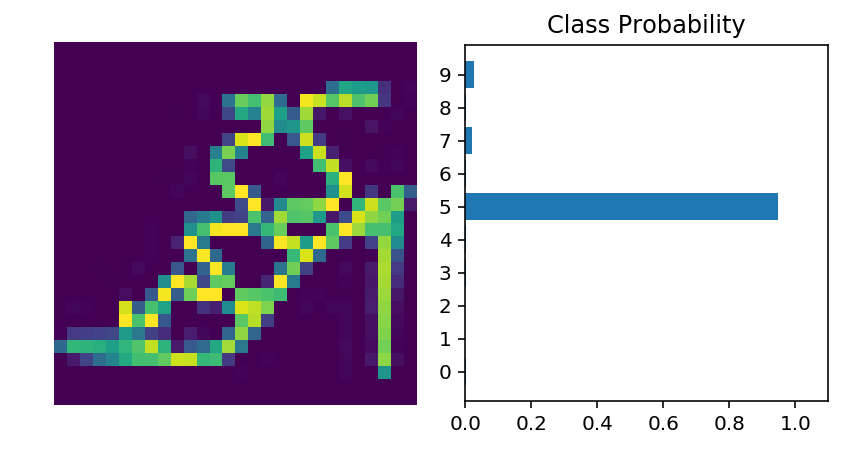

In [11]:
model.eval()

images, labels = next(iter(test_loader))
img = images[1]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(Variable(img, volatile=True))
    ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps)